In [1]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, wilcoxon
from chord import Chord
import operator
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler #used for 'Feature Scaling'
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Basic imports
import numpy as np
import pandas as pd

#############################
# Princple Feature Analysis #
# PFA is based on http://venom.cs.utsa.edu/dmz/techrep/2007/CS-TR-2007-011.pdf #
#############################

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler


In [2]:
def internalValidation(data, clusters):
    scores = {}
    """
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
    Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    """
    scores['_silhouette_score'] =metrics.silhouette_score(data,clusters ,metric='euclidean')
    """
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute
    """
    scores['_calinski_harabaz_score'] = metrics.calinski_harabaz_score(data,clusters)
    """
    Zero is the lowest possible score. Values closer to zero indicate a better partition.
    The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, 
    such as density based clusters like those obtained from DBSCAN.
    """
    scores['_davies_bouldin_score'] = metrics.davies_bouldin_score(data,clusters)
    return scores



In [3]:
# Data importing and some cleaning
'''
mdd_master = pd.read_excel('MDD Master Sheet Sapient.xlsx', 
                           header = [0,1], 
                           sheet_name = 'MasterImagingOnly',
                           skiprows=[85,86,87,88,89,90,91,92,93,94,95])
mdd_master.columns = ['{} {}'.format(i, j) for i, j in mdd_master.columns]
'''
#mdd_master =pd.read_csv('/Users/xinxing/Documents/MDD/New data/MDD_test/MDD_data_demo.csv')
df=pd.read_excel('/Users/xinxing/Documents/MDD/New data/MDD_test/May_03_2021/MDD_data_Gaurav.xlsx')

In [4]:
droplist=['7T ID','Label','madrs_sum','qids_score','mddonset','mddc_duration', 'madrs_sum',
         'pss_score','btq_score','lsc_score','ce_tleq','oc_tleq','qids_score','rrs_total',
         'shaps_score_1','shaps_score_2','bss_total','sticsa_somatic','sticsa_cognitive'
          ]
df=df[df.Status==0]
mdd_master=df.drop(droplist,axis=1)
mdd_master=mdd_master[mdd_master.Status==0]

In [5]:
mdd_master

,XNAT,Status,Age,Gender,Height,Weight,BMI,Race,Ethnicity,Education,...,N_Right-VentralDC,N_Right-vessel,N_Right-choroid-plexus,N_WM-hypointensities,N_Optic-Chiasm,N_CC_Posterior,N_CC_Mid_Posterior,N_CC_Central,N_CC_Mid_Anterior,N_CC_Anterior
0,S02794,0,40,M,1.524000,88.450523,38.082940,5,3.0,6.0,...,3.804401,0.025932,0.532276,1.894469,0.092779,1.071083,0.342685,0.428260,0.397046,0.982338
1,S02855,0,49,F,1.625603,74.842751,28.321785,5,2.0,NaN,...,3.505706,0.054691,0.707489,2.695649,0.132873,0.918633,0.341327,0.434571,0.477965,1.151384
2,S03843,0,45,M,1.752604,87.543339,28.500715,3,NaN,4.0,...,3.607140,0.012102,0.370024,2.645058,0.190682,1.041461,0.633224,0.542124,0.558800,1.224615
3,S04179,0,51,M,1.905004,117.934031,32.497312,5,2.0,5.0,...,3.724191,0.017628,0.840838,4.193174,0.091664,0.845333,0.539141,0.481499,0.507147,1.005833
4,S03872,0,55,M,1.778004,68.038864,21.522455,5,2.0,6.0,...,3.597112,0.061952,0.627542,1.993024,0.120772,0.928297,0.395101,0.402050,0.427790,1.045936
5,S05510,0,53,M,1.828804,99.790334,29.836942,5,1.0,2.0,...,3.957966,0.013144,0.540291,1.353151,0.188105,1.192518,0.491164,0.528332,0.494288,0.942896
6,S05486,0,39,F,1.701803,68.038864,23.492989,5,2.0,8.0,...,3.898135,0.088655,0.411647,0.836225,0.079911,0.987209,0.739755,0.506814,0.679660,0.825341
7,S06444,0,54,M,1.752604,74.842751,24.365896,5,2.0,5.0,...,3.432859,0.057682,0.693337,5.674513,0.052029,1.199062,0.374743,0.449960,0.659992,0.993821
8,S06720,0,29,F,1.676400,104.326258,37.122595,6,1.0,6.0,...,3.758795,0.000000,0.870250,2.967984,0.129657,1.122694,0.614419,0.618096,0.708469,1.206681
11,S07052,0,41,F,1.600203,49.895167,19.485350,5,2.0,8.0,...,3.811041,0.002389,0.537179,2.294796,0.146332,0.961843,0.482619,0.777922,0.734048,0.938209


In [6]:
demo_cat = [
'Gender',
# 'Race',
'Ethnicity',
'Education',
'Employment Status',
'Household Income',]

demo_cont = ['Height',
'Weight',
'BMI',
'Age',]

In [7]:
import tableone
table = tableone.TableOne(data=mdd_master, 
                          categorical = demo_cat,
                          groupby='Gender', 
                          pval=True,
                          columns = demo_cat+demo_cont,
                          htest_name=True,
                          smd = True,
                         sort='P-Value', label_suffix=True)

table.tabulate(tablefmt="html")



,,Missing,Overall,F,M,O,P-Value,Test,"SMD (F,O)","SMD (M,O)","SMD (F,M)"
n,,,42,17,24,1,,,,,
"Gender, n (%)",O,0,1 (2.4),,,1 (100.0),<0.001,Chi-squared (warning: expected count < 5),nan,nan,nan
,M,,24 (57.1),,24 (100.0),,,,,,
,F,,17 (40.5),17 (100.0),,,,,,,
"Height, mean (SD)",,0,1.7 (0.1),1.6 (0.1),1.8 (0.1),1.7 (0.0),<0.001,One-way ANOVA,1.932,-1.005,1.888
"Education, n (%)",2.0,1,2 (4.9),,2 (8.3),,0.014,Chi-squared (warning: expected count < 5),nan,nan,nan
,3.0,,2 (4.9),1 (6.2),,1 (100.0),,,,,
,4.0,,5 (12.2),2 (12.5),3 (12.5),,,,,,
,5.0,,4 (9.8),1 (6.2),3 (12.5),,,,,,
,6.0,,14 (34.1),6 (37.5),8 (33.3),,,,,,


In [8]:
def cluster_plot(data):
    
    list_of_features = data.columns
    StandardScaler = preprocessing.StandardScaler()
    x_scaled = StandardScaler.fit_transform(data)
    for n_clusters in range(2,3):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(x_scaled) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        pca_2d = PCA(n_components=3)
        PCs_2d = pca_2d.fit_transform(x_scaled)
        #clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", random_state=4)
        clusterer = AgglomerativeClustering(n_clusters = n_clusters,compute_full_tree=True)
        cluster_labels = clusterer.fit_predict(PCs_2d[:,1:3])

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette = []

        silhouette_avg = silhouette_score(x_scaled, cluster_labels)
        silhouette.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        #PCA with two principal components so we can dimensionality reduce the clusters found
        pca_2d = PCA(n_components=3)
        PCs_2d = pd.DataFrame(pca_2d.fit_transform(x_scaled)).to_numpy()
        ax2.scatter(PCs_2d[:, 1], PCs_2d[:, 2], marker='.', s=200, lw=0, alpha=0.7,c=colors, edgecolor='k')
        '''
        # Labeling the clusters
        circle_pts = []
        unique_clusters = set(cluster_labels)
        for item in unique_clusters:
            mean_point = PCs_2d[cluster_labels == item].mean(axis=0)
            circle_pts.append(mean_point)

        # Draw white circles at cluster centers
        circle_array = np.array(circle_pts)
        ax2.scatter(circle_array[:, 0], circle_array[:, 1], marker='o',
                    c="white", alpha=1, s=10**3, edgecolor='k')

        for i, c in enumerate(circle_pts):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=100, edgecolor='k')
        '''
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("PCA Reduction: Dimension 1")
        ax2.set_ylabel("PCA Reduction: Dimension 2")

        plt.suptitle(("Silhouette analysis: "
                      " Cluster Number = %d" % n_clusters),fontsize=14, fontweight='bold')

    plt.show()

    '''
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
    plt.rcParams['axes.facecolor'] = 'lightgray'


    plt.plot(range_n_clusters, 
             silhouette, 
             marker='o',
             linestyle='--',
             alpha=1,)

    plt.title("Silhouette Value by Cluster")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    '''

def db_plot(data, eps):
    '''
    x_scaled should be min_max processed
    eps should be determined by the plot ouputted in this function
    returns cluster assignments
    '''
    list_of_features = data.columns
    min_max_scaler = preprocessing.MinMaxScaler()
    data[list_of_features] = min_max_scaler.fit_transform(data)
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(x_scaled)
    distances, indices = nbrs.kneighbors(x_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    m = DBSCAN(eps=1, min_samples=2)
    m.fit(x_scaled)
    clusters = m.labels_
    return clusters


def kmeans_feature_selection(data, n_desired_features, n_clusters=2):
    '''
    iteratively performs k_means clustering to determine features that would be useful for clustering
    n_desired_features = how many features you want
    data - non-normalizied data
    '''

    list_of_features = list(data.columns)
    min_max_scaler = preprocessing.MinMaxScaler()
    data[list_of_features] = min_max_scaler.fit_transform(data)
#     print(data[list_of_features])
    # initialize the feature_counter and total list of features
    feature_counter = 0
    selected_features = []
    while len(selected_features) < n_desired_features:
        holder = {}
        for current_feature in list_of_features:
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(data[[current_feature]+selected_features])
            silhouette_avg = silhouette_score(data[[current_feature]+selected_features], cluster_labels)
            print(cluster_labels)
            holder[current_feature] = silhouette_avg        
        # append with the max sillhouette key
        max_key = max(holder.items(), key=operator.itemgetter(1))[0]
        selected_features.append(max(holder.items(), key=operator.itemgetter(1))[0])
        print('max sil value: {}'.format(holder[max_key]))
        print(selected_features)
        list_of_features.remove(max_key)
    return selected_features

/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Hierarchical Clustering

In [9]:
#######################################################
# Getting clustering dataset
#######################################################
droplist=['Status',"XNAT", "Age","Gender",'Height','Weight',
          'BMI','Race','Ethnicity','Education','Employment Status', 'Household Income']
spectral_df = mdd_master.drop(droplist,axis=1)
#     'Normalized FreeSurfer Amygdala Volumes',
#     'Normalized ASHS Hippocampal Subfield Volime',
scaler = MinMaxScaler()
spectral_df_scaled = scaler.fit_transform(spectral_df)

/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
spectral_df

/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,LGbankssts,RGbankssts,LGcaudalanteriorcingulate,RGcaudalanteriorcingulate,LGcaudalmiddlefrontal,RGcaudalmiddlefrontal,LGcuneus,RGcuneus,LGentorhinal,RGentorhinal,...,N_Right-VentralDC,N_Right-vessel,N_Right-choroid-plexus,N_WM-hypointensities,N_Optic-Chiasm,N_CC_Posterior,N_CC_Mid_Posterior,N_CC_Central,N_CC_Mid_Anterior,N_CC_Anterior
0,0.692037,0.926458,0.873107,0.656190,0.999534,0.945153,1.081475,1.071910,1.995308,2.755230,...,3.804401,0.025932,0.532276,1.894469,0.092779,1.071083,0.342685,0.428260,0.397046,0.982338
1,0.769288,0.672186,0.746320,0.386555,0.904909,0.917148,1.043521,1.058555,2.209610,2.035781,...,3.505706,0.054691,0.707489,2.695649,0.132873,0.918633,0.341327,0.434571,0.477965,1.151384
2,0.700487,0.639677,0.571418,0.726768,0.989624,1.027669,1.087187,1.175107,2.032376,2.401985,...,3.607140,0.012102,0.370024,2.645058,0.190682,1.041461,0.633224,0.542124,0.558800,1.224615
3,0.708357,0.908720,0.568597,0.551355,0.774782,0.788512,1.082807,1.475029,2.018647,1.948069,...,3.724191,0.017628,0.840838,4.193174,0.091664,0.845333,0.539141,0.481499,0.507147,1.005833
4,0.836215,0.820591,0.647992,0.603947,0.824631,0.925841,0.984638,1.150488,1.896828,2.007906,...,3.597112,0.061952,0.627542,1.993024,0.120772,0.928297,0.395101,0.402050,0.427790,1.045936
5,0.728620,0.686920,0.667295,0.630623,0.711153,0.843063,1.221158,0.993051,1.788822,2.198131,...,3.957966,0.013144,0.540291,1.353151,0.188105,1.192518,0.491164,0.528332,0.494288,0.942896
6,0.789364,0.725552,0.534554,0.542937,0.852594,0.929424,1.163934,1.235867,2.049417,2.455630,...,3.898135,0.088655,0.411647,0.836225,0.079911,0.987209,0.739755,0.506814,0.679660,0.825341
7,1.055743,0.828030,0.524291,0.733029,0.811731,0.908342,1.157681,1.018315,1.615803,2.011552,...,3.432859,0.057682,0.693337,5.674513,0.052029,1.199062,0.374743,0.449960,0.659992,0.993821
8,0.781890,0.729160,0.603173,0.630762,0.955269,0.847379,1.070093,1.243793,2.652565,2.759009,...,3.758795,0.000000,0.870250,2.967984,0.129657,1.122694,0.614419,0.618096,0.708469,1.206681
11,0.821998,0.679218,0.642572,0.577840,0.988026,0.897753,1.096379,1.061582,2.757447,2.220690,...,3.811041,0.002389,0.537179,2.294796,0.146332,0.961843,0.482619,0.777922,0.734048,0.938209


/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 2 The average silhouette_score is : 0.018524146588984096


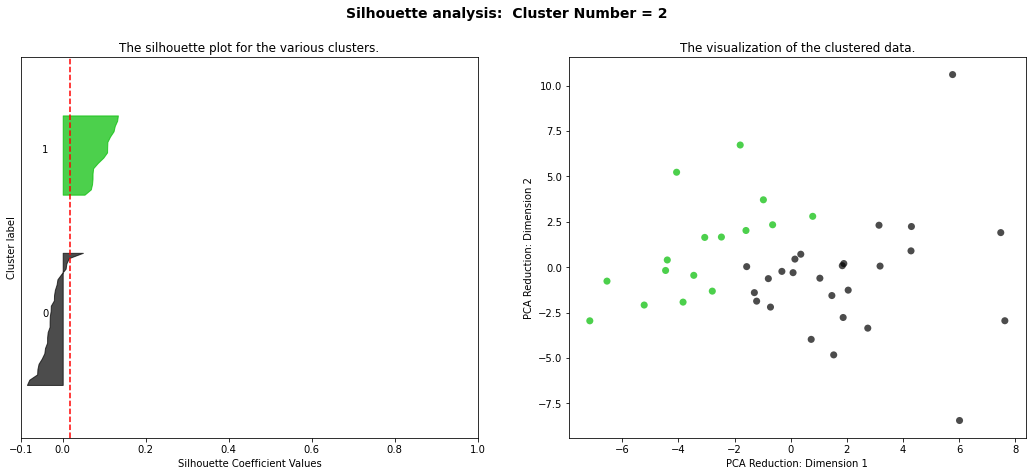

In [11]:
#######################################################
# Clustering
#######################################################

from sklearn.cluster import SpectralClustering

import numpy as np
for_df = []
# for k in range(2,8):
#     clustering = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(spectral_df_scaled)
#     results_int = internalValidation(spectral_df_scaled, clustering.labels_)
#     results_int['clusters'] = k
#     for_df.append(results_int)
#     print(results_int)


scaler = StandardScaler()
scaler.fit(spectral_df)
X=scaler.transform(spectral_df)

pca_2d = PCA(n_components=3)
PCs_2d = pca_2d.fit_transform(X)

#Spectral Clustering:
#clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=4).fit(PCs_2d[:,2:4])

#HC:
clustering = AgglomerativeClustering(n_clusters = 2,compute_full_tree=True).fit(PCs_2d[:,1:3])


#clustered = mdd_master
clustered = df#.iloc[spectral_df.index]
clustered['cluster'] = clustering.labels_
'''
newcols = []
for item in clustered.columns: 
    newcols.append(item[0]+' '+item[1])
clustered.columns = newcols
'''
cluster_plot(spectral_df)

In [12]:
#######################################################
# Imaging metrics
#######################################################

import tableone
clustered['cluster'] = clustering.labels_
dataSN=clustered.drop('XNAT',axis=1)
table = tableone.TableOne(data=dataSN, 
                          groupby='cluster', 
                          pval=True,
                         htest_name=True,
                         sort='P-Value', label_suffix=True)

table.tabulate(tablefmt="html")
table.to_excel('PC2vsPC3_HC.xlsx')



/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [13]:
#######################################################
# Demographics table
#######################################################

demos = ['Age', 'Gender', 'Height',
       'Weight', 'BMI', 'Race',
       'Ethnicity', 'Education',
       'Employment Status', 'Household Income',]

table = tableone.TableOne(data=clustered, 
                          categorical = ['Gender', 
                                         #'Race',
                                         #'Ethnicity', 
                                         #'Education',
                                         'Employment Status', 
                                         'Household Income',
                                        ],
                          groupby='cluster', 
                          pval=True,
                          columns = demos,
                         htest_name=True,
                         sort='P-Value', label_suffix=True)

table.tabulate(tablefmt="html")
#table.to_excel('PC2vsPC3_hc_demo.xlsx')



/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,Missing,Overall,0,1,P-Value,Test
n,,,42,26,16,,
"Height, mean (SD)",,0,1.7 (0.1),1.8 (0.1),1.7 (0.1),0.055,Two Sample T-test
"Race, mean (SD)",,0,4.6 (1.2),4.9 (1.0),4.1 (1.4),0.064,Two Sample T-test
"Gender, n (%)",O,0,1 (2.4),,1 (6.2),0.084,Chi-squared (warning: expected count < 5)
,M,,24 (57.1),18 (69.2),6 (37.5),,
,F,,17 (40.5),8 (30.8),9 (56.2),,
"Weight, mean (SD)",,0,78.2 (19.7),81.0 (18.7),73.7 (21.0),0.264,Two Sample T-test
"Ethnicity, mean (SD)",,1,1.9 (0.4),2.0 (0.5),1.8 (0.4),0.285,Two Sample T-test
"Age, mean (SD)",,0,38.2 (11.5),36.7 (10.6),40.6 (12.9),0.319,Two Sample T-test
"Employment Status, n (%)",3.0,3,11 (28.2),6 (24.0),5 (35.7),0.512,Chi-squared (warning: expected count < 5)


In [14]:
scorelist=['madrs_sum','qids_score','mddonset','mddc_duration', 
         'pss_score','lsc_score','ce_tleq','oc_tleq','rrs_total',
         'shaps_score_1','shaps_score_2','bss_total','sticsa_somatic','sticsa_cognitive'
          ]

scoretable = tableone.TableOne(data=clustered, 
                          #categorical = scorelist,
                          groupby='cluster', 
                          pval=True,
                         columns = scorelist,
                         htest_name=True,
                         sort='P-Value', 
                         label_suffix=True
                              )

scoretable.tabulate(tablefmt="html")
scoretable.to_excel('PC2vsPC3_hc_score.xlsx')


/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#######################################################
# Neuropsychiatric
#######################################################
'''
import tableone
table = tableone.TableOne(data=clustered, 
                          categorical = ['Male = 0 Gender', 'Male = 0 Race', 'Male = 0 Ethnicity', 'Male = 0 Education'],
                          groupby='cluster', 
                          pval=True,
                          columns = neuropsych+['cluster',"MDD = 0 Age"],
                         htest_name=True,
                         sort='P-Value', label_suffix=True)

table.tabulate(tablefmt="html")
'''


/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nimport tableone\ntable = tableone.TableOne(data=clustered, \n                          categorical = [\'Male = 0 Gender\', \'Male = 0 Race\', \'Male = 0 Ethnicity\', \'Male = 0 Education\'],\n                          groupby=\'cluster\', \n                          pval=True,\n                          columns = neuropsych+[\'cluster\',"MDD = 0 Age"],\n                         htest_name=True,\n                         sort=\'P-Value\', label_suffix=True)\n\ntable.tabulate(tablefmt="html")\n'

In [16]:
#######################################################
# Score graph
#######################################################
'''
scores = pd.DataFrame(for_df).set_index('clusters')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=200) 
fig.set_size_inches(8, 12)
fig.suptitle("The silhouette plot for the various clusters.")
fig.subplots_adjust(top=0.92)

ax1.set_ylabel("Silhouette Coefficient")
ax1.plot(scores.index,scores['_silhouette_score'], 'o',color='b')
ax2.plot(scores.index,scores['_calinski_harabaz_score'],'x',color='m' )
ax3.plot(scores.index,scores['_davies_bouldin_score'],'--', color='c' )
ax2.set_ylabel("Calinski-Harabaz Score")
ax3.set_ylabel("Davies Bouldin Score")
ax3.set_xlabel("Cluster label")
fig.savefig('sill_plot.png')
'''

/Users/xinxing/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nscores = pd.DataFrame(for_df).set_index(\'clusters\')\nfig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=200) \nfig.set_size_inches(8, 12)\nfig.suptitle("The silhouette plot for the various clusters.")\nfig.subplots_adjust(top=0.92)\n\nax1.set_ylabel("Silhouette Coefficient")\nax1.plot(scores.index,scores[\'_silhouette_score\'], \'o\',color=\'b\')\nax2.plot(scores.index,scores[\'_calinski_harabaz_score\'],\'x\',color=\'m\' )\nax3.plot(scores.index,scores[\'_davies_bouldin_score\'],\'--\', color=\'c\' )\nax2.set_ylabel("Calinski-Harabaz Score")\nax3.set_ylabel("Davies Bouldin Score")\nax3.set_xlabel("Cluster label")\nfig.savefig(\'sill_plot.png\')\n'